In [27]:
from dataset.dataloader import get_loader, get_loader_inference 
from dataset.data_split_fold import datafold_read, datafold_read_inference

from monai.utils import first, set_determinism
import matplotlib.pyplot as plt
import json

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    SpatialPadd,
    MapTransform,
    EnsureChannelFirstd,
    Rotate90d, 
    Flipd,
    Lambdad,
    ToTensord
)

from monai.data import (
    DataLoader,
    Dataset,
)

from typing import Dict, Any

In [28]:
def datafold_read(dataset_json, fold=0, key="training"):
    with open(dataset_json) as f:
        json_data = json.load(f)
    json_data = json_data[key]
    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)
    return tr, val

In [29]:


class MultiplyImageLabeld(MapTransform):
    def __call__(self, data: Dict[str, Any]) -> Dict[str, Any]:
        data = dict(data)
        data["image"] = data["image"] * data["label"]
        return data

In [30]:
transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label"]),
        Rotate90d(keys=["image", "label"], spatial_axes=(0, 1)),
        Flipd(keys=["label"], spatial_axis=0),
        Lambdad(keys=["label"], func=lambda label: (label >= 1) * 1),
        ScaleIntensityRanged(keys=["image"],
                                a_min=-175,
                                a_max=250,
                                b_min=0.0,
                                b_max=1.0,
                                clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        CropForegroundd(keys=["image", "label"], source_key="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, .25, 2.0),
            mode=("bilinear", "nearest"),
        ),
        
        # Multiply image with label
        MultiplyImageLabeld(keys=["image", "label"]),  # keys parameter is optional here
        #EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96), mode='constant'),
        ToTensord(keys=["image"]),
    ]
)

In [34]:

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label"]),
        Rotate90d(keys=["image", "label"], spatial_axes=(0, 1)),
        Flipd(keys=["label"], spatial_axis=0),
        Lambdad(keys=["label"], func=lambda label: (label >= 1) * 1),
        ScaleIntensityRanged(keys=["image"],
                                a_min=-175,
                                a_max=250,
                                b_min=0.0,
                                b_max=1.0,
                                clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        CropForegroundd(keys=["image", "label"], source_key="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, .25, 2.0),
            mode=("bilinear", "nearest"),
        ),
        
        # Multiply image with label
        MultiplyImageLabeld(keys=["image", "label"]),  # keys parameter is optional here
        #EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96), mode='constant'),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image"]),
    ]
)

In [35]:
dataset_json = './dataset/dataset_json_files/training_data_nikhil_debug.json'
# Split the dataset into train and validation subsets 
train_files, val_files = datafold_read(dataset_json) 

train_ds = Dataset(data=train_files, 
                    transform=train_transforms)

train_loader = DataLoader(
train_ds, 
batch_size=1)        

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


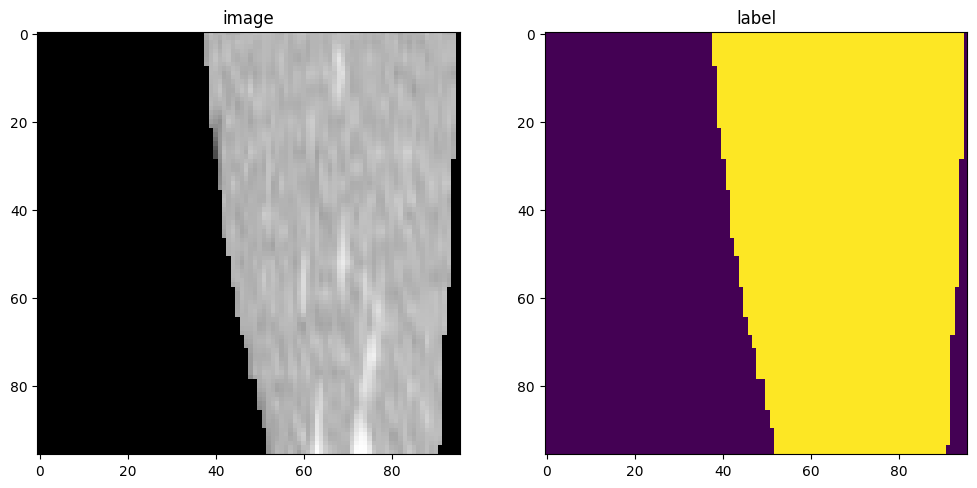

In [36]:
check_data = first(train_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 35], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 35])
plt.show()

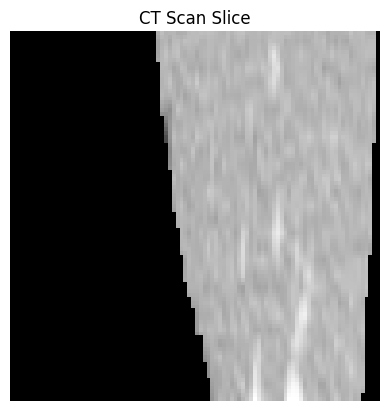

In [37]:
# Display a slice
slice_index = image.shape[2] // 2  # Middle slice
slice_index = 35
plt.imshow(image[:, :, slice_index], cmap='gray')
plt.title("CT Scan Slice")
plt.axis("off")
plt.show()